In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/planet-understanding-the-amazon-from-space'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv


In [2]:
import keras as kr
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from os import listdir

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/train-data/train_v2.csv')
train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Getting unique tags
train_val = train['tags'].values
split = [x.split(' ') for x in train_val]
lst = []
for sublst in split:
    lst += sublst
labels = list(set(lst))
labels

['blooming',
 'slash_burn',
 'clear',
 'road',
 'artisinal_mine',
 'agriculture',
 'primary',
 'water',
 'haze',
 'bare_ground',
 'cultivation',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'blow_down',
 'habitation',
 'selective_logging']

In [5]:
# Mapping tags
dic = {}
for x, y in enumerate(labels):
    dic[y] = x
dic

{'blooming': 0,
 'slash_burn': 1,
 'clear': 2,
 'road': 3,
 'artisinal_mine': 4,
 'agriculture': 5,
 'primary': 6,
 'water': 7,
 'haze': 8,
 'bare_ground': 9,
 'cultivation': 10,
 'cloudy': 11,
 'partly_cloudy': 12,
 'conventional_mine': 13,
 'blow_down': 14,
 'habitation': 15,
 'selective_logging': 16}

In [6]:
# Image encoding
x_train = []
y_train = []

for x, tags in tqdm(train.values, miniters=1500):
    img = cv2.imread('/kaggle/input/trainjpg/train-jpg/{}.jpg'.format(x))
    targets = np.zeros(17)
    for tag in tags.split(' '):
        targets[dic[tag]] = 1
    x_train.append(cv2.resize(img, (32,32)))
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [06:52<00:00, 98.03it/s] 


(40479, 32, 32, 3)
(40479, 17)


In [7]:
# Splitting data
split = 33000
x_train, x_test, y_train, y_test = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

In [8]:
# 1st Model training
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                activation='relu',
                input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

In [9]:
history = model.fit(x_train, y_train,
             batch_size=128,
             epochs=6,
             verbose=1,
             validation_data=(x_test, y_test))

Epoch 1/6
258/258 [==============================] - 75s 284ms/step - loss: 0.2518 - accuracy: 0.1786 - val_loss: 0.2046 - val_accuracy: 0.1576
Epoch 2/6
258/258 [==============================] - 75s 290ms/step - loss: 0.2098 - accuracy: 0.1855 - val_loss: 0.1932 - val_accuracy: 0.2019
Epoch 3/6
258/258 [==============================] - 72s 280ms/step - loss: 0.1963 - accuracy: 0.1959 - val_loss: 0.1807 - val_accuracy: 0.2035
Epoch 4/6
258/258 [==============================] - 71s 276ms/step - loss: 0.1876 - accuracy: 0.2004 - val_loss: 0.1734 - val_accuracy: 0.1994
Epoch 5/6
258/258 [==============================] - 73s 282ms/step - loss: 0.1806 - accuracy: 0.2072 - val_loss: 0.1698 - val_accuracy: 0.2095
Epoch 6/6
258/258 [==============================] - 71s 277ms/step - loss: 0.1768 - accuracy: 0.2155 - val_loss: 0.1663 - val_accuracy: 0.2002


In [10]:
# validate model
valid = model.predict(x_test, batch_size=128)

59/59 [==============================] - 3s 57ms/step


In [11]:
valid

array([[7.7471016e-03, 8.3121244e-04, 9.7546560e-01, ..., 7.6094002e-04,
        3.8655445e-03, 3.3229140e-03],
       [9.1115581e-03, 1.2320869e-03, 9.7224897e-01, ..., 1.1133776e-03,
        6.9978251e-03, 4.6302588e-03],
       [1.8260586e-04, 6.5865665e-04, 9.8112530e-01, ..., 6.2369370e-05,
        4.4537559e-01, 3.7460378e-04],
       ...,
       [5.2309118e-04, 8.5019576e-04, 9.9083495e-01, ..., 1.3923508e-04,
        4.0673622e-01, 1.7764254e-03],
       [2.5126894e-04, 6.4007752e-04, 8.8543248e-01, ..., 9.9862780e-05,
        2.4649364e-01, 3.3053977e-04],
       [8.0522811e-03, 1.1276075e-02, 2.9186106e-01, ..., 7.9459436e-03,
        8.8266648e-02, 1.7770972e-02]], dtype=float32)

Text(0.5, 1.0, 'Loss Curves - before tweaking')

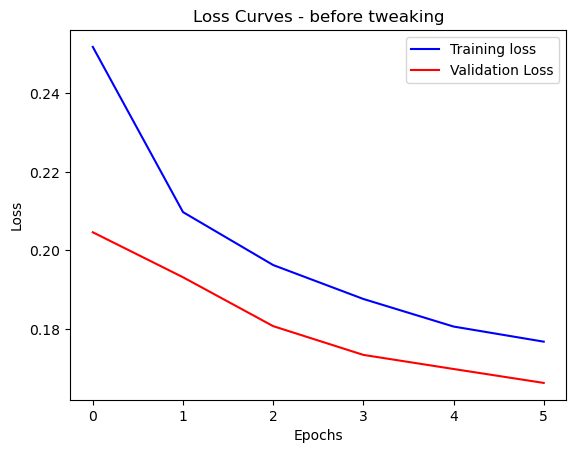

In [12]:
# visuals of loss function
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before tweaking')

In [13]:
# 2nd model with more layers
model = Sequential()
# Block 1
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 2
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 3
model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train,
                 batch_size=128,
                 epochs=6,
                 verbose=1,
                 validation_data=(x_test, y_test))

Epoch 1/6
258/258 [==============================] - 137s 524ms/step - loss: 0.2095 - accuracy: 0.1865 - val_loss: 0.1673 - val_accuracy: 0.2435
Epoch 2/6
258/258 [==============================] - 133s 516ms/step - loss: 0.1582 - accuracy: 0.2109 - val_loss: 0.1470 - val_accuracy: 0.1936
Epoch 3/6
258/258 [==============================] - 133s 517ms/step - loss: 0.1417 - accuracy: 0.2213 - val_loss: 0.1380 - val_accuracy: 0.1782
Epoch 4/6
258/258 [==============================] - 133s 516ms/step - loss: 0.1336 - accuracy: 0.2317 - val_loss: 0.1312 - val_accuracy: 0.2059
Epoch 5/6
258/258 [==============================] - 132s 513ms/step - loss: 0.1278 - accuracy: 0.2532 - val_loss: 0.1253 - val_accuracy: 0.2561
Epoch 6/6
258/258 [==============================] - 133s 518ms/step - loss: 0.1222 - accuracy: 0.2420 - val_loss: 0.1286 - val_accuracy: 0.2079


In [15]:
valid = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(valid) > 0.2, beta=2, average='samples'))

59/59 [==============================] - 7s 114ms/step
0.8858934971791359


Text(0.5, 1.0, 'Loss Curves - after tweaking')

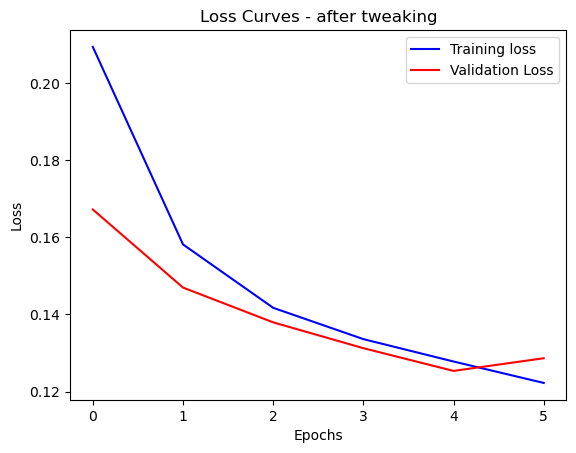

In [16]:
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after tweaking')

In [17]:
x_test = []
x_test_add = []
img_title = []
img_title_add = []

for x in tqdm(listdir('/kaggle/input/trainjpg/train-jpg'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/trainjpg/train-jpg/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (32,32)))
    img_title.append(img_name)
    
for x in tqdm(listdir('/kaggle/input/trainjpg/train-jpg'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/trainjpg/train-jpg/{}.jpg'.format(img_name))
    x_test_add.append(cv2.resize(img, (32,32)))
    img_title_add.append(img_name)
    
x_test = np.array(x_test, np.float16) / 255
x_test_add = np.array(x_test_add, np.float16) / 255

100%|██████████| 40479/40479 [01:42<00:00, 396.71it/s]


In [18]:
pred1 = model.predict(x_test, batch_size=128)
pred2 = model.predict(x_test_add, batch_size=128)

317/317 [==============================] - 37s 116ms/step


In [19]:
image1 = []
tags1 = []
for i, img in enumerate(img_title):
    image1.append(img)
    tags1.append(' '.join(np.array(labels)[pred1[i] > 0.2]))
df1 = pd.DataFrame()
df1['image_name'] = image1
df1['tags'] = tags1

image2 = []
tags2 = []
for i, img in enumerate(img_title_add):
    image2.append(img)
    tags2.append(' '.join(np.array(labels)[pred2[i] > 0.2]))
df2 = pd.DataFrame()
df2['image_name'] = image2
df2['tags'] = tags2

In [20]:
full_df = pd.concat([df1, df2])
full_df

,image_name,tags
0,train_30370,clear primary
1,train_11814,clear primary
2,train_14358,road agriculture primary water partly_cloudy
3,train_18588,clear primary
4,train_36435,clear primary water
...,...,...
40474,train_14628,clear primary
40475,train_27150,primary haze
40476,train_25524,clear agriculture primary cultivation
40477,train_35401,clear agriculture primary water


In [21]:
full_df.to_csv('submission.csv', index=False)

In [22]:
pd.read_csv('/kaggle/working/submission.csv')

,image_name,tags
0,train_30370,clear primary
1,train_11814,clear primary
2,train_14358,road agriculture primary water partly_cloudy
3,train_18588,clear primary
4,train_36435,clear primary water
...,...,...
80953,train_14628,clear primary
80954,train_27150,primary haze
80955,train_25524,clear agriculture primary cultivation
80956,train_35401,clear agriculture primary water
